In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Diffusity

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [20]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [21]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

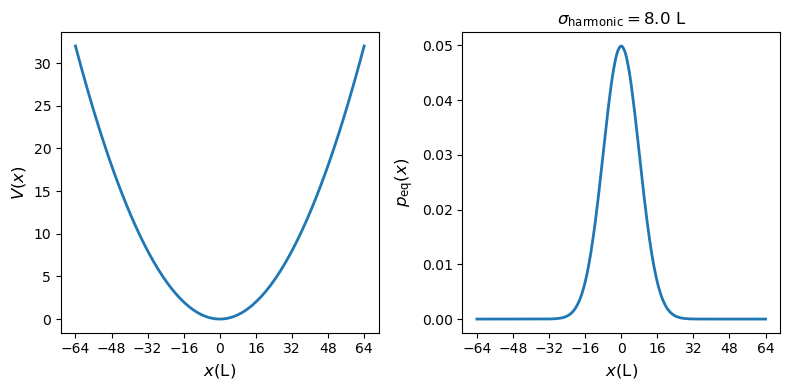

In [221]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [22]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [23]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

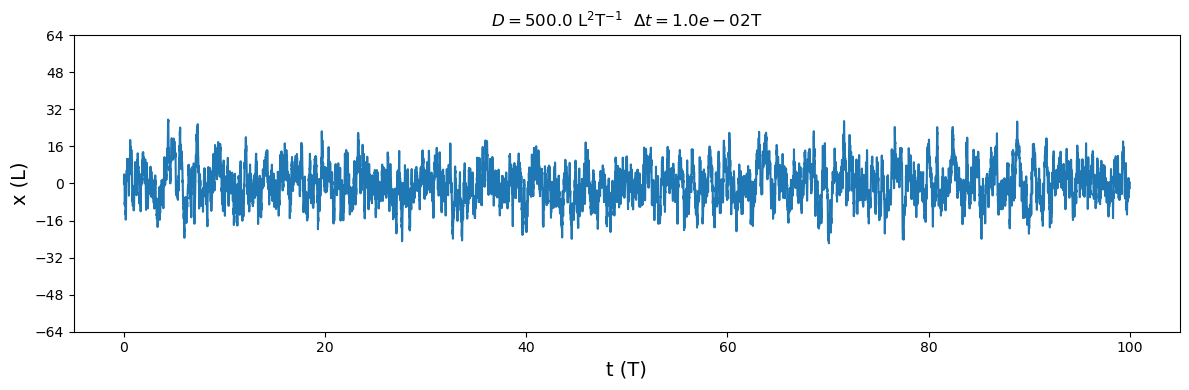

In [193]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues when $D=1$

In [24]:
D_unity = 1e0
eigenvalues_prime, eigenvect_mat_prime, rho_eq_by_fem_prime = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_unity, Nv)
weight_Qx_prime = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime);

### Part 5: Set Photon $\sigma$

In [25]:
σ_delta = 2.0
k_delta = get_k_by_sigma(σ_delta);

### Part 6: Set $p(x,0)$

In [36]:
time_idx = 1
idx = find_nearest_point(y_record[time_idx], xref, e_norm, interpo_xs, Np)
p_x0 = get_gaussian(k_delta, xref, idx)
p_x0 = p_x0 ./ sum(w0 .* p_x0);

In [37]:
sum(w0 .* p_x0)

1.0

### Part 7: get $a_k$

In [38]:
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat_prime)
ak_array = transpose(weight_Qx) * sqrt.(p_x0);

### Part 8: Plot 1

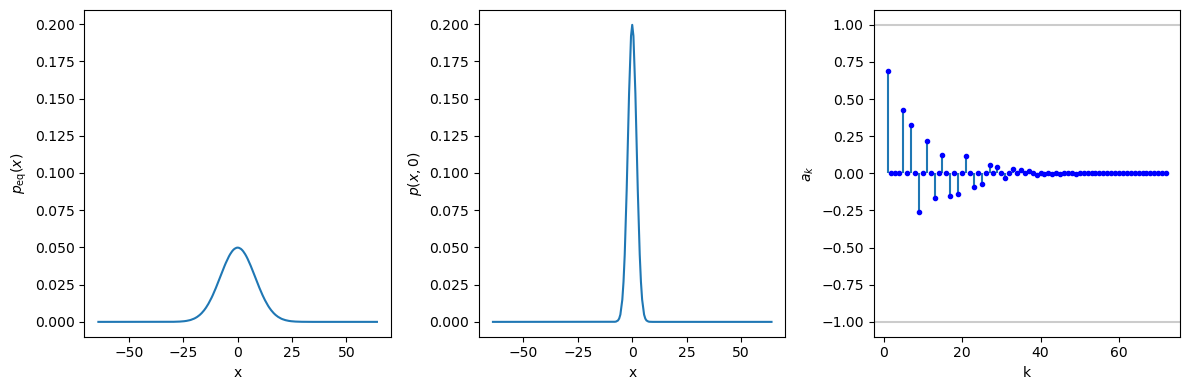

In [40]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_eq)
ax.set_xlabel("x")
ax.set_ylabel("\$p_{\\mathrm{eq}}(x)\$")

ax = axes[2]
ax.plot(xref, p_x0)
ax.set_xlabel("x")
ax.set_ylabel("\$p(x,0)\$")

axes[1].set_ylim(ax.get_ylim())

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, ak_array, "b.")
ax.vlines(xarray, ymin=0, ymax=ak_array)
ax.set_ylabel("\$a_k\$")
ax.set_xlabel("k")
ax.axhline(1, color="grey", alpha=0.4)
ax.axhline(-1, color="grey", alpha=0.4)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/A_deltat_1.svg")
plt.show()

### Part 9-1: Calculate Sensitivity Coefficient

In [52]:
k = 2
D_k = 1
delta_t = 1e-2

0.01

In [53]:
c_k = ak_array[k] * eigenvalues_prime[k] * delta_t * exp(-D_k * eigenvalues_prime[k] * delta_t)

iner_term = 0.
temp = 0.
for eigv_idx=2:Nv
    temp = ak_array[eigv_idx]^2 * exp(-2 * D_k * eigenvalues_prime[eigv_idx] * delta_t)
    iner_term += temp
end
last_term = 2 * eigenvalues_prime[k] * delta_t * ak_array[k]^2 * exp(-2 * D_k * eigenvalues_prime[k] * delta_t)
c_1 = sign(ak_array[1]) * (1/2) * (1 / sqrt(1-temp)) * last_term

1.6262340145216555e-26

In [54]:
c_k

-1.5940484960905829e-15

In [90]:
sele_col_id = 24
sum(A_mat[:,sele_col_id])

0.9999999999999998